# import

In [22]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from pprint import pprint
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora, models
import numpy as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import codecs
from konlpy.tag import Twitter
from gensim.models import word2vec
from konlpy.utils import pprint
from sklearn.manifold import TSNE
%matplotlib inline

# char 코드 기반 자연어 처리

In [2]:
ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語の文章です。'
en_str = 'This is English Sentences.'
ch_str = '统一码'

In [3]:
print(ord(ko_str[0]))  # 각각의 문자들은 개별적인 코드를 가짐.
print(ord(ja_str[0]))
print(ord(en_str[0]))
print(ord(ch_str[0]))

51060
12371
84
32479


In [4]:
def count_codePoint(str):  # unicode 출현 빈도 판정
    counter = np.zeros(65535)  # 저장배열 준비
    for i in range(len(str)):  # 각 문자 unicode 포인트 변환
        code_point = ord(str[i])
        if code_point > 65535:
            continue
        counter[code_point] += 1  # 출현횟수 측정

    counter = counter/len(str)  # 정규화
    return counter

In [5]:
X_train = [count_codePoint(ko_str), count_codePoint(
    ja_str), count_codePoint(en_str)]
y_train = ['ko', 'ja', 'en']

In [6]:
print(X_train[0])
np.where(X_train[0] > 0)  # 0보다 큰 index값 출력

[0. 0. 0. ... 0. 0. 0.]


(array([   32,    46, 44163, 44397, 45768, 45796, 47928, 50612, 51008,
        51060, 51077, 51109, 54620], dtype=int64),)

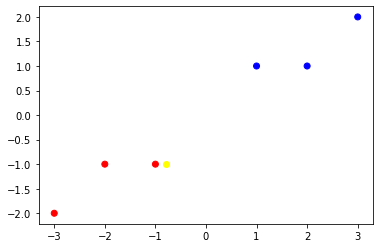

In [7]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])


color = [ 'red' if y == 1 else 'blue' for y in Y]

plt.scatter(X[:, 0], X[:, 1], color=color)

t = np.array([[-0.8, -1]])

plt.scatter(t[:,0], t[:,1], color='yellow')

In [8]:
clf = GaussianNB()
clf.fit(X, Y)
print(clf.predict([[-0.8, -1]]))

[1]


In [9]:
clf.fit([[0,0], [0,1], [1,0], [1,1]], [0,1,1,0])
print(clf.predict([[0, 1]]))

[0]


In [10]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
y_pred = clf.predict([count_codePoint('안녕, 잘지내')])
print(y_pred) # 학습데이터의 분포 파악을 통해 입력 언어의 종류 도출(code 분포 범위 다름)

['ko']


In [12]:
y_pred = clf.predict([count_codePoint('レモン')])
print(y_pred)

['ja']


## 문자 셋이 동일한경우 (동일한 알파벳 사용)

In [15]:
X_train = []
y_train = []

for file in glob.glob('./train/*.txt'):
    y_train.append(file[8:10]) # 언어정보 추출, 레이블 지정
    file_str = '' # 파일 내부의 문자열 모두 추출, 배열변환, 입력데이터 사용
    for line in open(file, 'r', encoding='UTF8'):
        file_str += line
    X_train.append(count_codePoint(file_str))

In [16]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
X_test = []
y_test = []

for file in glob.glob('./test/*.txt'):
    y_test.append(file[7:9])
    file_str = '' 
    for line in open(file, 'r', encoding='UTF8'):
        file_str += line
    X_test.append(count_codePoint(file_str))

In [18]:
y_pred = clf.predict(X_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

['de' 'en' 'es']
정답률 =  1.0


In [21]:
y_pred = clf.predict(count_codePoint(''))
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

TypeError: ord() expected a character, but string of length 43 found

# 단어 빈도수 기반 자연어 처리

## 단어 빈도수 기반

In [26]:
a = ["he", "123", "124124"]
b = ".".join(a)
print(b) # list a의 요소를 '.'으로 연결

he.123.124124


In [3]:
corpus = [
    "you know I want your love",
    "I like you",
    "what should I do"
]
str = " ".join(corpus)
print(str)

words = str.split(' ')
print(words)  # 문자열 parsing, 개별적인 단어로 쪼갬

freq = {}
for w in words:
    freq[w] = freq.get(w, 0) + 1  # 빈도 측정
print(freq)

you know I want your love I like you what should I do
['you', 'know', 'I', 'want', 'your', 'love', 'I', 'like', 'you', 'what', 'should', 'I', 'do']
{'you': 2, 'know': 1, 'I': 3, 'want': 1, 'your': 1, 'love': 1, 'like': 1, 'what': 1, 'should': 1, 'do': 1}


In [4]:
vector = CountVectorizer()
tf = vector.fit_transform(corpus)
print(tf)
print(tf.toarray())

  (0, 7)	1
  (0, 1)	1
  (0, 5)	1
  (0, 8)	1
  (0, 3)	1
  (1, 7)	1
  (1, 2)	1
  (2, 6)	1
  (2, 4)	1
  (2, 0)	1
[[0 1 0 1 0 1 0 1 1]
 [0 0 1 0 0 0 0 1 0]
 [1 0 0 0 1 0 1 0 0]]


In [41]:
print(tf.shape)  # 문장, 단어수

(3, 9)


In [39]:
print(vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

{'you': 7, 'know': 1, 'want': 5, 'your': 8, 'love': 3, 'like': 2, 'what': 6, 'should': 4, 'do': 0}


In [42]:
print(vector.vocabulary_['you'])
print(vector.vocabulary_.get('you'))   

7
7


In [43]:
words = vector.get_feature_names()
for word in words: print(word)
    
for key in vector.vocabulary_: 
    print(key, vector.vocabulary_[key])

do
know
like
love
should
want
what
you
your
you 7
know 1
want 5
your 8
love 3
like 2
what 6
should 4
do 0


## TF-IDF (Term Frequency - Inverse Document Frequency)

* TF: 현재 문서에서 단어 A가 나타난 횟수
* DF: 단어가 나타난 문서의 수
* 특정 단어의 상대적인 빈도를 나타내 주는 값
* 값이 클수록 내 문서에서만 많이 언급되는 단어(=다른 문서에서는 언급 적음)
* 값이 작을수록 다른 문서에 잘 언급하는 단어(=현재 문서와 관련 없음)

<img src=tfidf.png>

In [49]:
sent = ["오늘 휴일",
        "휴일 오늘",
        "휴일 인 오늘 도 서쪽 을 중심 으로 폭염 이 이어졌는데요, 내일 은 반가운 비 소식 이 있습니다.",
        "폭염 을 피해서 휴일 에 놀러왔다가 갑작스런 비 로 인해 망연자실 하고 있습니다.",
        " 내일 은 반가운 비 소식 이 있습니다."]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sent)  # 문장 벡터화 진행
print(tfidf_matrix)
print(type(tfidf_matrix))
print(tfidf_matrix.toarray().shape)
print(tfidf_matrix.toarray())  # 그 문장에서만 언급된 특정 단어의 값만 높게 나타남, 의미없는단어 = 0에 가까움

  (0, 16)	0.6437444595062429
  (0, 7)	0.7652405313723362
  (1, 16)	0.6437444595062429
  (1, 7)	0.7652405313723362
  (2, 11)	0.2395176261700136
  (2, 6)	0.2885440493005532
  (2, 4)	0.2885440493005532
  (2, 1)	0.2885440493005532
  (2, 9)	0.35764291175439183
  (2, 13)	0.2885440493005532
  (2, 8)	0.35764291175439183
  (2, 12)	0.35764291175439183
  (2, 5)	0.35764291175439183
  (2, 16)	0.20148977802380913
  (2, 7)	0.2395176261700136
  (3, 15)	0.36719000140970626
  (3, 3)	0.36719000140970626
  (3, 10)	0.36719000140970626
  (3, 0)	0.36719000140970626
  (3, 2)	0.36719000140970626
  (3, 14)	0.36719000140970626
  (3, 11)	0.24591142337923544
  (3, 13)	0.29624658112109614
  (3, 16)	0.20686844180323766
  (4, 11)	0.43218340623561463
  (4, 6)	0.5206462341406692
  (4, 4)	0.5206462341406692
  (4, 1)	0.5206462341406692
<class 'scipy.sparse.csr.csr_matrix'>
(5, 17)
[[0.         0.         0.         0.         0.         0.
  0.         0.76524053 0.         0.         0.         0.
  0.         0.       

In [50]:
features = tfidf_vectorizer.get_feature_names()
print(features)

['갑작스런', '내일', '놀러왔다가', '망연자실', '반가운', '서쪽', '소식', '오늘', '으로', '이어졌는데요', '인해', '있습니다', '중심', '폭염', '피해서', '하고', '휴일']


In [54]:
mat = np.asarray(tfidf_matrix.toarray())
srch = ['오늘', '휴일']
print([tfidf_vectorizer.vocabulary_.get(i) for i in srch])
srch_dtm = mat[:, [tfidf_vectorizer.vocabulary_.get(i) for i in srch]]
srch_dtm = mat[:, [7, 16]]
print(srch_dtm)

[7, 16]
[[0.76524053 0.64374446]
 [0.76524053 0.64374446]
 [0.23951763 0.20148978]
 [0.         0.20686844]
 [0.         0.        ]]


In [55]:
score = srch_dtm.sum(axis=1)
print(score)

[1.40898499 1.40898499 0.4410074  0.20686844 0.        ]


In [56]:
for i in range(len(score)):
    if score[i] > 0:
        print('{}/score:{}'.format(sent[i], score[i]))

오늘 휴일/score:1.408984990878579
휴일 오늘/score:1.408984990878579
휴일 인 오늘 도 서쪽 을 중심 으로 폭염 이 이어졌는데요, 내일 은 반가운 비 소식 이 있습니다./score:0.4410074041938227
폭염 을 피해서 휴일 에 놀러왔다가 갑작스런 비 로 인해 망연자실 하고 있습니다./score:0.20686844180323766


In [57]:
sentences = ['This is the first document.',
              'This is the second document.',
              'And the third one.',
              'Is this the first document?']
vect = TfidfVectorizer()
X = vect.fit_transform(sentences)

In [58]:
y = [1,2,3,4]
model =  SGDClassifier(loss='perceptron')  
model.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
X_pred = vect.transform(['My new document third'])
y_pred = model.predict(X_pred)
print(y_pred)

[3]


## 빈도수 기반 텍스트의 긍정/부정 평가 (영문)

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)  # 단어 빈도수 상위 10000개 사용

17465344/17464789 [==============================] - 1s 0us/step


In [6]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))
# 이 경우에는 긍정을 의미하는 1의 값을 가집니다. 0은 부정

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [7]:
print(X_train[0])
print(X_train[1])
print(len(X_train[0]))   
print(len(X_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 1

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


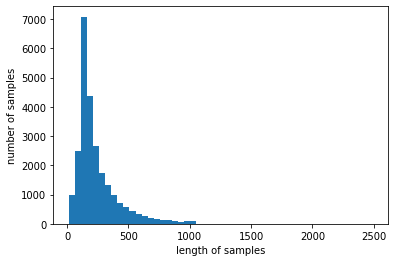

In [8]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
word_to_index = imdb.get_word_index()    # 없으면 다운로드함

1646592/1641221 [==============================] - 0s 0us/step


In [10]:
word_to_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [11]:
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [12]:
index_to_word

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [13]:
print(index_to_word[1])
print(index_to_word[14])

the
as


In [14]:
' '.join([index_to_word[X] for X in X_train[0]])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have t

In [15]:
X_train_s = [' '.join([index_to_word[X] for X in X_train[i]]) 
             for i in range(len(X_train))  ]
X_test_s = [' '.join([index_to_word[X] for X in X_test[i]]) 
            for i in range(len(X_test))  ]

In [16]:
X_train_s[600]

"the places and social i i was one life is seriously br highly views fact many should movie of and of jane did subsequently escapes to criminals disc \x96 was supposed strange light of directed end his form first as unlikely or sex in gang of you it cockney film walter love and or is time death guy moment see knew such of violence happen between finally should movie even then through some more then through some more vanessa also have what would role have vanessa car have to what would language have poor performances it br on son i i as you landscape time over being quickly to in at shooting was against laugh read has when giant to jr with irs moving any movie from he out is save br and weren't decent like ever family even scientist and an from people it critics to and unfortunately of problem on to what of decent tells passing were romeo no from people and of insights he used funniest has catches jane it's don't by br of decent help with cute and football mildred no poor never stinks w

In [17]:
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(X_train_s + X_test_s)

xtrain_count = count_vect.transform(X_train_s)
xtest_count = count_vect.transform(X_test_s) # 단어 사용 빈도 측정

In [18]:
[1,2,3,4] + [5,6]

[1, 2, 3, 4, 5, 6]

In [19]:
print(xtrain_count.shape) 

(25000, 9774)


In [20]:
print(len(X_train[0]))  # 218개의 단어, 굉장히 많음. the 등 의미없는 데이터 많음.

218


In [21]:
print(xtrain_count[0])  # 데이터의 차원에 비해 의미있는 데이터의 양이 많지 않음.

  (0, 138)	1
  (0, 224)	1
  (0, 312)	1
  (0, 456)	3
  (0, 463)	6
  (0, 523)	1
  (0, 527)	2
  (0, 597)	1
  (0, 632)	3
  (0, 676)	1
  (0, 681)	1
  (0, 829)	1
  (0, 893)	1
  (0, 1005)	1
  (0, 1069)	1
  (0, 1151)	2
  (0, 1299)	3
  (0, 1340)	1
  (0, 1529)	1
  (0, 1580)	1
  (0, 2171)	1
  (0, 2220)	1
  (0, 2668)	1
  (0, 3021)	1
  (0, 3114)	2
  :	:
  (0, 8766)	1
  (0, 8772)	2
  (0, 8779)	3
  (0, 8780)	1
  (0, 8792)	2
  (0, 8816)	1
  (0, 8889)	9
  (0, 9094)	2
  (0, 9173)	1
  (0, 9318)	1
  (0, 9382)	1
  (0, 9442)	1
  (0, 9466)	3
  (0, 9470)	1
  (0, 9475)	1
  (0, 9544)	1
  (0, 9550)	2
  (0, 9555)	1
  (0, 9557)	1
  (0, 9575)	1
  (0, 9593)	1
  (0, 9633)	11
  (0, 9655)	1
  (0, 9732)	1
  (0, 9744)	6


In [22]:
model = LinearSVC()
model.fit(xtrain_count, y_train)  # 모델 학습 (LinearSVC:단층 퍼셉트론보다 조금 나은 성능)

C:\Users\student\Documents\GitHub\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [28]:
y_pred = model.predict(xtest_count)
print(len(y_pred))
print(y_pred)
sum((y_test == y_pred)* 1)/len(y_pred) *100 # 전체 문장의 긍/부정 평가

25000
[0 1 1 ... 0 0 1]


83.0

In [31]:
text = "good day"
text_count = count_vect.transform([text])
y_pred = model.predict(text_count)           #원하는 텍스트의 긍정/부정 평가
print(y_pred)

[0]


In [34]:
tfidf_vect = TfidfVectorizer(analyzer='word')
tfidf_vect.fit(X_train_s+X_test_s)
xtrain_tfidf = tfidf_vect.transform(X_train_s)
xtest_tfidf = tfidf_vect.transform(X_test_s)

In [35]:
model = LinearSVC()
model.fit(xtrain_tfidf, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [36]:
y_pred = model.predict(xtest_tfidf)
print(len(y_pred))
print(y_pred)
sum((y_test == y_pred)* 1)/len(y_pred)

25000
[0 1 1 ... 0 0 1]


0.87456

In [39]:
text = "This is just a scam from ActiBlizzard awful company since Activision touch our beloved Blizzard, the real focus of that garbage company is just steal your money"
# 액티비전이 우리의 사랑하는 블리자드를 건드린 이후
# 액티비즈 끔찍한 회사의 사기극일 뿐이야
# 그 쓰레기 회사의 진짜 초점은 네 돈을 훔치는 거야

text_tfidf = tfidf_vect.transform([text])
y_pred = model.predict(text_tfidf)
print(y_pred)

[0]


## 한글 형태소 분석

In [2]:
okt = Okt()

In [4]:
malist = okt.pos("난 장난 안하고 진짜 재밌게 봤는데 다들 싫어하네", norm=True, stem=True)
print(malist)

[('난', 'Noun'), ('장난', 'Noun'), ('안', 'Noun'), ('하고', 'Josa'), ('진짜', 'Noun'), ('재밌다', 'Adjective'), ('보다', 'Verb'), ('다', 'Adverb'), ('들다', 'Verb'), ('싫어하다', 'Adjective')]


In [7]:
print(okt.nouns(u'난 장난 안하고 진짜 재밌게 봤는데 다들 싫어하네'))
print(okt.pos(u'아니 이게 되네 ㅋㅋ'))
print(okt.pos(u'아니 이게 되네 ㅋㅋ', norm=True, stem=True))

['난', '장난', '안', '진짜']
[('아니', 'Adjective'), ('이', 'Noun'), ('게', 'Josa'), ('되네', 'Verb'), ('ㅋㅋ', 'KoreanParticle')]
[('아니다', 'Adjective'), ('이', 'Noun'), ('게', 'Josa'), ('되다', 'Verb'), ('ㅋㅋ', 'KoreanParticle')]


In [8]:
kkma = Kkma()
# 문장분리
print('Kkma 문장 분리:', kkma.sentences('원숭이 신의 잃어버린 도시'))
# 명사추출
print('Kkma 명사만 추출:', kkma.nouns('원숭이 신의 잃어버린 도시'))

Kkma 문장 분리: ['원숭이 신의 잃어버린 도시']
Kkma 명사만 추출: ['원숭이', '신의', '도시']


* 빈도수 기반 표현은 단어간 의미차를 표현할 수 없음
* 단어 자체 의미 자체를 다차원 공간에서 벡터화 필요
* 단어들 사이의 유사도 측정 가능
* 단어들 간의 평균, 및 연산을 통해 추론 가능

> 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 방법

* 윈도우 슬라이딩을 통해 데이터셋 생성 ( 한 문장으로 중심단어, 주변단어를 통해 training set 구성 가능) 

## word to vec 기초

# word to vector 기초

> 단어에 대한 벡터연산. 학습된 데이터 내에서 단어 사이의 관계(연관성) 파악 가능

* 분산표현 : 분포가설 - (가정) 비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다.
* 중심단어와 주변단어 벡터의 내적이 코사인 유사도가 되도록 단어벡터를 벡터공간에 임베딩

In [51]:
sentences = [
                ['this', 'is', 'a',   'good',      'product'],
                ['it',   'is', 'a',   'excellent', 'product'],
                ['it',   'is', 'a',   'bad',       'product'],
                ['that', 'is', 'the', 'worst',     'product']
            ]

# 문장을 이용하여 단어와 벡터를 생성한다.
model = Word2Vec(sentences, size=5, window=3, min_count=1) # min_count = 등장횟수 지정

In [52]:
# 단어벡터를 구한다.
word_vectors = model.wv

In [53]:
print(word_vectors["this"])
print(word_vectors["the"])

[ 0.03823866  0.06411918  0.05618201  0.03646433 -0.09559694]
[ 0.09197789  0.08854622 -0.07521462 -0.00518093 -0.02044056]


In [54]:
vocabs = word_vectors.vocab.keys()
print(vocabs)

dict_keys(['this', 'is', 'a', 'good', 'product', 'it', 'excellent', 'bad', 'that', 'the', 'worst'])


In [55]:
word_vectors_list = [word_vectors[v] for v in vocabs]
print(word_vectors_list)

[array([ 0.03823866,  0.06411918,  0.05618201,  0.03646433, -0.09559694],
      dtype=float32), array([ 0.08209082,  0.07706904, -0.03895061,  0.00564391, -0.05637126],
      dtype=float32), array([-0.04702679,  0.00341562,  0.09478915,  0.06827784,  0.01743268],
      dtype=float32), array([-0.01630032,  0.05616945, -0.04633762, -0.03603172, -0.03042446],
      dtype=float32), array([-0.07039692,  0.01917198, -0.0878581 ,  0.02362036, -0.05959199],
      dtype=float32), array([-0.0974218 ,  0.06705528, -0.06031543,  0.01000798, -0.05615323],
      dtype=float32), array([ 0.0231363 ,  0.05020045,  0.01645317,  0.09320927, -0.04939055],
      dtype=float32), array([ 0.04045427,  0.09927925, -0.05847033, -0.09087083,  0.0311033 ],
      dtype=float32), array([-0.01620097, -0.08421294,  0.09954397, -0.07694817, -0.08946941],
      dtype=float32), array([ 0.09197789,  0.08854622, -0.07521462, -0.00518093, -0.02044056],
      dtype=float32), array([-0.07599535,  0.04212495,  0.08769272, -0.

In [56]:
print(model.wv.similarity(w1='it', w2='the'))

0.12065403


In [57]:
model.wv.most_similar('it')

[('product', 0.8997073173522949),
 ('good', 0.7445995807647705),
 ('worst', 0.40898582339286804),
 ('excellent', 0.22025234997272491),
 ('bad', 0.1597757637500763),
 ('this', 0.14577867090702057),
 ('is', 0.14382204413414001),
 ('the', 0.12065404653549194),
 ('a', -0.06542950868606567),
 ('that', -0.22802114486694336)]

In [58]:
def read_data(filename):
    with open(filename, encoding='utf-8', mode='r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:] # header 제외
    return data # train data 생성 함수

In [59]:
ratings_train = read_data('ratings_train.txt')

In [45]:
print(ratings_train[0])

['9976970', '아 더빙.. 진짜 짜증나네요 목소리', '0']


In [46]:
okt = Okt()
def tokens(doc):
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

In [47]:
tokens('아 더빙.. 진짜 짜증나네요 목소리')

['아/Exclamation',
 '더빙/Noun',
 '../Punctuation',
 '진짜/Noun',
 '짜증나다/Adjective',
 '목소리/Noun']

In [48]:
# 파일중에서 영화 리뷰 데이터만 담기
docs = []
for row in ratings_train:
    docs.append(row[1])
print(docs[:10])

['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다', '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.', '원작의 긴장감을 제대로 살려내지못했다.', '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네', '액션이 없는데도 재미 있는 몇안되는 영화', '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']


In [49]:
data = [tokens(d) for d in docs]

In [84]:
w2v_model = word2vec.Word2Vec(data, size=100, window=3)

In [85]:
w2v_model.save('naver.model')

In [78]:
print(w2v_model.wv.most_similar(positive=tokens(
    u'남자 여배우'), negative=tokens(u'배우'), topn=5))  # topn = 출력값 갯수
# 단어 간 관련도 파악 가능
# 남자 - 배우 = 여자 - 여배우

[('여자/Noun', 0.84222012758255), ('아빠/Noun', 0.7383322715759277), ('여자애/Noun', 0.7254758477210999), ('할아버지/Noun', 0.7034949064254761), ('아버지/Noun', 0.701072096824646)]


In [79]:
print(w2v_model.wv.most_similar(tokens('봉준호')))

[('류승완/Noun', 0.9058403372764587), ('파커/Noun', 0.9006196856498718), ('박철수/Noun', 0.8968778252601624), ('봉만대/Noun', 0.8953800201416016), ('보루/Noun', 0.8949477672576904), ('앤더슨/Noun', 0.8936904668807983), ('길예르모/Noun', 0.8928245902061462), ('레오네/Noun', 0.8912780284881592), ('틴토/Noun', 0.8882287740707397), ('신카이/Noun', 0.8821178674697876)]


In [86]:
vocabs = w2v_model.wv.vocab.keys()
print(len(vocabs))

15409


차원축소 15409 -> x~ -> 2 or 3

In [96]:
vocab = list(w2v_model.wv.vocab)
X = w2v_model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:300,:])

C:\Users\student\Documents\GitHub\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


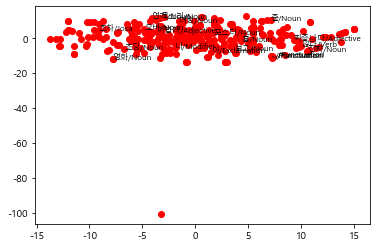

In [97]:
from matplotlib import font_manager, rc
import matplotlib as mpl
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.scatter(X_tsne[:,0], X_tsne[:,1], c='red')

words = vocab[:20]    
for i, word in enumerate(words):
    plt.text(X_tsne[i,0], X_tsne[i,1 ], word, fontsize=8) 
plt.savefig('out.png', dpi=200)

C:\Users\student\Documents\GitHub\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\student\Documents\GitHub\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


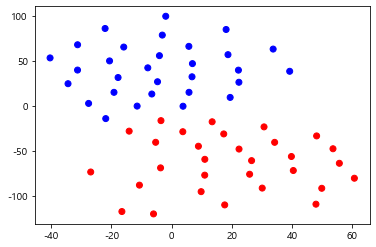

In [99]:
group1 = w2v_model.wv.most_similar(tokens('김치'), topn=30)
group1 = [w for ( w,  s )  in  group1 ]
X1 = w2v_model[group1]

group2 = w2v_model.wv.most_similar(tokens('정우성'), topn=30)
group2 = [w for ( w,  s )  in  group2 ]
X2 = w2v_model[group2]

X_tsne =tsne.fit_transform(np.vstack([X1, X2]))

label = np.hstack([0*np.ones(30), np.ones(30)  ])
c = [ 'red'  if l == 0  else 'blue'  for l in label ]


plt.scatter(X_tsne[:,0], X_tsne[:,1], color=c) # 2차원으로 줄인 결과니 실제 연관성과는 다르게 보일 수 있음

# word embedded RNN

* RNN(Recurrent Neural Network)
> 순환신경망 : 일반 신경망은 개별 데이터를 독립적으로 학습.
은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력과 은닉층 노드의 다음 계산의 입력으로 보냄.
RNN에서는 노드를 셀이라고 하고 이전의 값을 기억하려고 하는 일종의 메모리 역할을 수행.
시계열 데이터 학습에 적합.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import sequence
from keras.preprocessing.sequence import  pad_sequences
from keras.datasets import imdb

from konlpy.tag import Okt
import statsmodels.api as sm
%matplotlib inline

Using TensorFlow backend.


In [103]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2,10)))   #   input_lengtg는 입력 시컨스의 길이
# model.add(SimpleRNN(3, input_length=2, input_dim=10))와 동일함.
model.summary()
# 크기는 hidden 갯수와 dim에 의해 결정됨
# wx = 3 *  10  = 30      입력에서 hidden으로   
# wh = 3 * 3    = 9       출력이 hidden*hidden이므로   
# b = 3         = 3              -> 42개   # 출력층의 hidden

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


## RNN을 이용한 시계열 데이터 분석 예시

In [115]:
step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]   # 800, 200개로 분할

print(train.shape)
print(test.shape)

(800, 1)
(200, 1)


In [118]:
seq = [1,2,3,4,5,6,7]
sp = 3

seq = [1,2,3,4,5,6,7,7,7,7]
#  3개의 seq 길이를 갖도록 학습 데이터 seq 생성
#  1,2,3,4,5,6,7,0,0,0                   [1,2,3]      [4] 
#                                      [2,3,4]       [5]   
#                                       [7,7,7]       [7] 

In [119]:
train = np.append(train,np.repeat(train[-1,],step))  # 마지막값을 step만큼 반복
test = np.append(test,np.repeat(test[-1,],step))

In [120]:
print(train.shape)
print(test.shape)

(804,)
(204,)


In [121]:
print(train[:10])
print(train[798:])

[0.69134814 0.54666782 1.50408549 1.16197045 1.08628273 1.56857989
 1.10123757 0.41668242 1.84702541 0.61379461]
[0.94033386 0.59468049 0.59468049 0.59468049 0.59468049 0.59468049]


In [122]:
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])                   #주어진 시계열 데이터로부터 y생성
 return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

print(trainX.shape)
print(trainY.shape)

(800, 4)
(800,)


In [123]:
print(train[:10])
print(trainX[0])
print(trainX[1])
print(trainY[0])
print(trainY[1])

[0.69134814 0.54666782 1.50408549 1.16197045 1.08628273 1.56857989
 1.10123757 0.41668242 1.84702541 0.61379461]
[0.69134814 0.54666782 1.50408549 1.16197045]
[0.54666782 1.50408549 1.16197045 1.08628273]
1.0862827319175847
1.5685798880494428


In [124]:
#3차원 shape으로 구성
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

(800, 1, 4)


In [125]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="tanh"))
model.add(Dense(8, activation="tanh")) 
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=0)

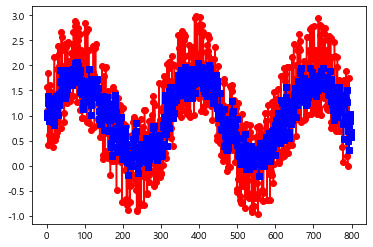

In [126]:
plt.plot(trainY, 'ro-', label="target")
plt.plot(model.predict(trainX), 'bs-', label="output")

(-3, 3)

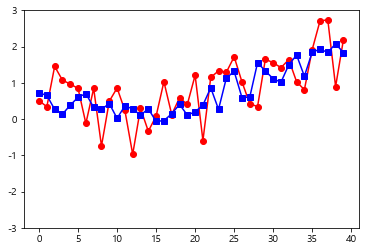

In [114]:
plt.plot(testY[0::5], 'ro-', label="target")
plt.plot(model.predict(testX[0::5]), 'bs-', label="output") #0부터 끝까지 5씩 증가
plt.ylim([-3,3])